In [ ]:
#mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing various python libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
from pylab import rcParams
from matplotlib.patches import Patch #importing required library for plotting visualizations
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#loading the dataset into dataframe
df = pd.read_csv('/content/drive/MyDrive/ME781_Dataset_Insurance/train.csv')

##Exploratory Data Analysis (EDA)
Before we begin with creation of the model and prediction, it becomes useful to explore the data we are working with, the data scales of the features, visualize any trends that may be present between a variable and the output to be predicted, etc. to choose the most suitable model for our purpose. We will explore the training dataset accordingly.

In [ ]:
df.head() #displaying the first 5 entries of dataframe

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
print('Dataframe number of records in dataset= '+str(df.shape[0]))
print('Dataframe number of variables (including the class) = '+str(df.shape[1]))

Dataframe number of records in dataset= 381109
Dataframe number of variables (including the class) = 12


We observe from above that our training dataset is large in size, and so we can also utilize a part of this (by splitting it) for cross validation and hyperparameter tuning as well as for testing to assess our accuracy. 

In [ ]:
df.dtypes #outputs the datatype of the variables

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
for column in df.columns.values: #outputting the number of unique values for each column of the dataset
  listofunique= pd.unique(df[column])
  print(column+ ' has ' + str(len(listofunique))+ ' unique values ')

id has 381109 unique values 
Gender has 2 unique values 
Age has 66 unique values 
Driving_License has 2 unique values 
Region_Code has 53 unique values 
Previously_Insured has 2 unique values 
Vehicle_Age has 3 unique values 
Vehicle_Damage has 2 unique values 
Annual_Premium has 48838 unique values 
Policy_Sales_Channel has 155 unique values 
Vintage has 290 unique values 
Response has 2 unique values 


This helps us understand which variables are categorical or numerical, and which ones are distinct for each customer (eg. id) which may not help in building our model which is a generalized construct.

In [ ]:
for column in df.columns.values: #outputting the number of null values for each column of the dataset
  print(column+ ' has ' + str(df[column].isna().sum()) + ' null values ')

id has 0 null values 
Gender has 0 null values 
Age has 0 null values 
Driving_License has 0 null values 
Region_Code has 0 null values 
Previously_Insured has 0 null values 
Vehicle_Age has 0 null values 
Vehicle_Damage has 0 null values 
Annual_Premium has 0 null values 
Policy_Sales_Channel has 0 null values 
Vintage has 0 null values 
Response has 0 null values 


No null values present in our dataset to be taken care of.

The histogram for Gender is: 



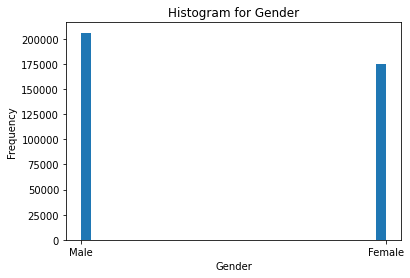

The histogram for Age is: 



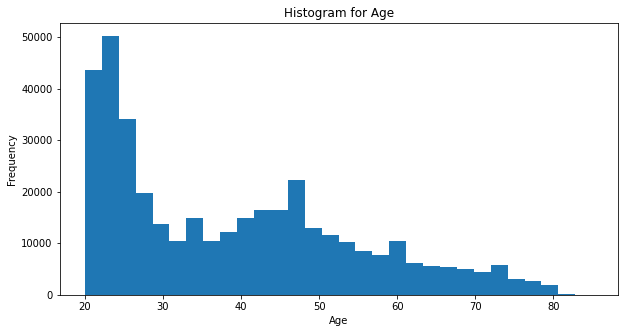

The histogram for Driving_License is: 



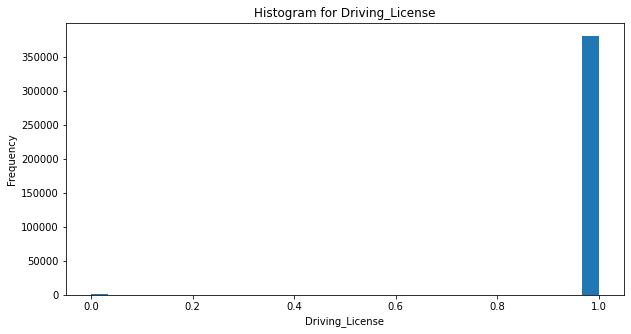

The histogram for Region_Code is: 



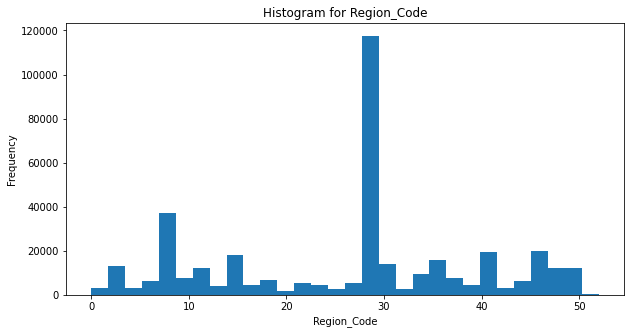

The histogram for Previously_Insured is: 



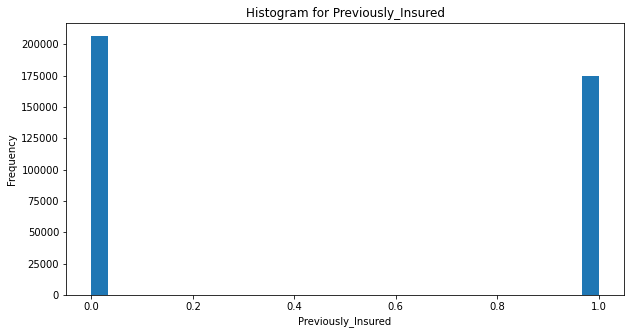

The histogram for Vehicle_Age is: 



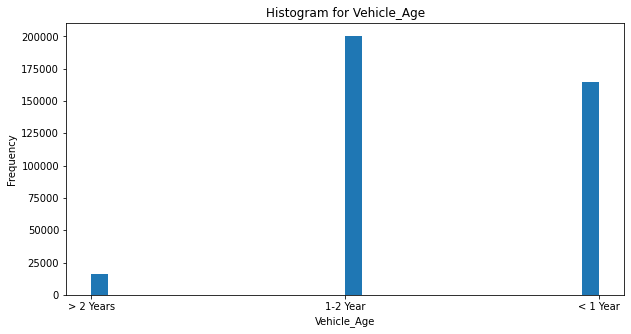

The histogram for Vehicle_Damage is: 



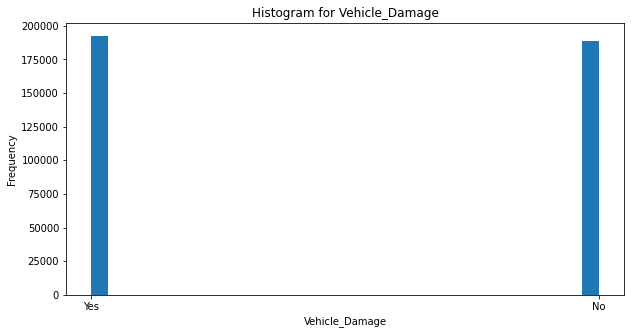

The histogram for Annual_Premium is: 



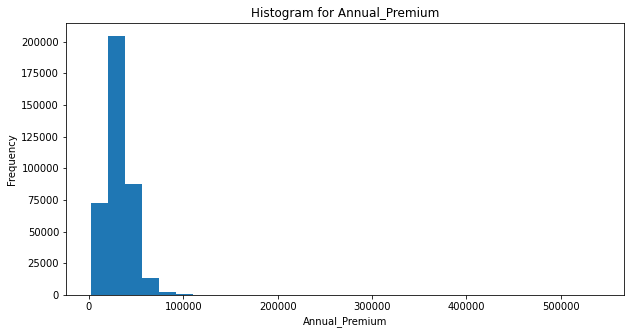

The histogram for Policy_Sales_Channel is: 



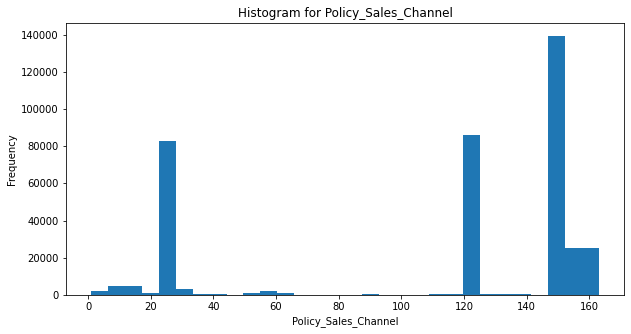

The histogram for Vintage is: 



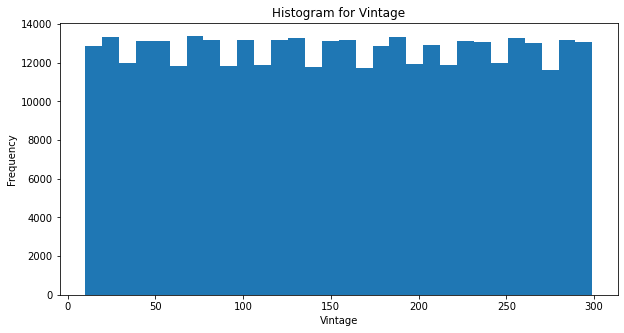

The histogram for Response is: 



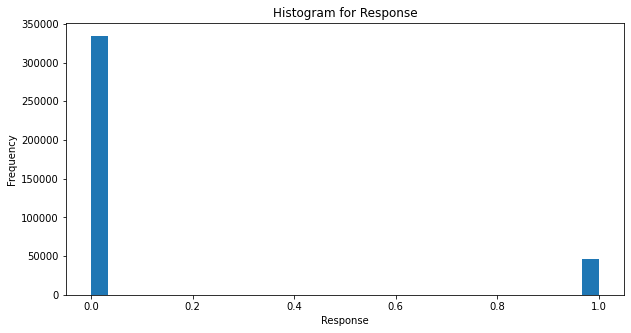

In [ ]:
#plotting histograms of all the columns
df2=df.drop(columns=['id']) #dropping columns which have no sense in plotting a histogram for
for col in df2.columns.values:
 print('The histogram for '+col+' is: ')
 plt.hist(df2[col], bins=30)
 plt.title('Histogram for '+col)
 print()
 plt.xlabel(col)
 plt.ylabel('Frequency')
 rcParams['figure.figsize'] = 10, 5
 plt.show();

The main takeaway from the above histograms is the histogram of Response being highly partial, with the majority of our dataset having 0 as their response. We deal with this fact later on while building our model. As expected most of our customers have a drivers license, and other variables have their distribution as shown above.

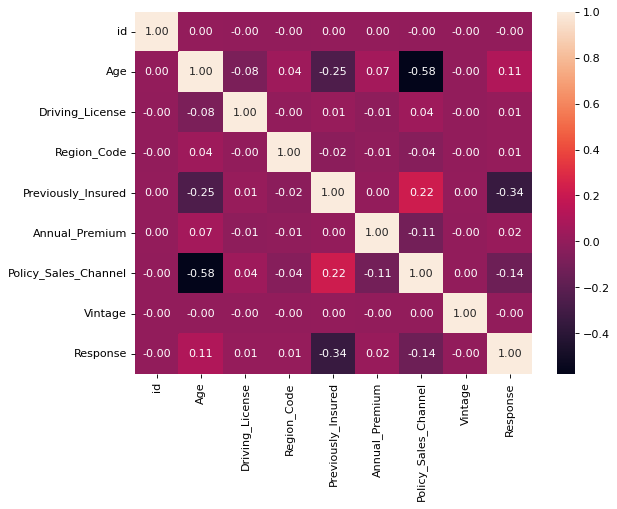

In [ ]:
#Plotting a heatmap to see the correlation between the various continuous variables
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

We observe from the above heatmap that the age of the vehile and policy sales channel are highly correlated positively. The Response of the customer is dependent on the fact that whether or not they have been previously ensured, with them being correlated by -0.34 (i.e. negatively).

The qq plot for Age is: 


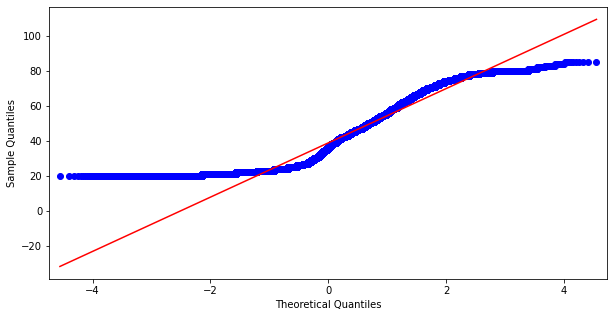


The qq plot for Region_Code is: 


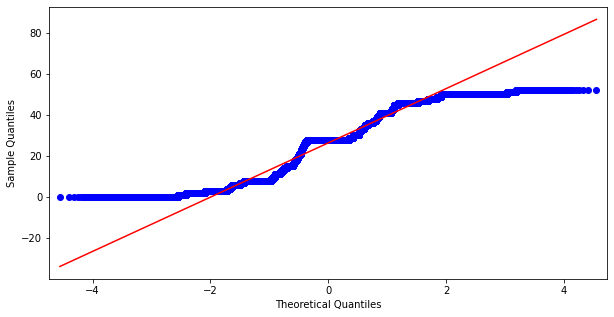


The qq plot for Annual_Premium is: 


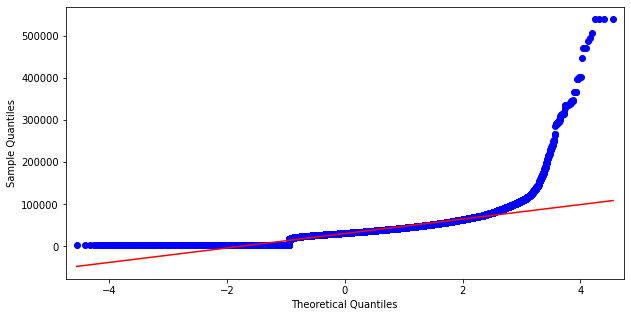


The qq plot for Vintage is: 


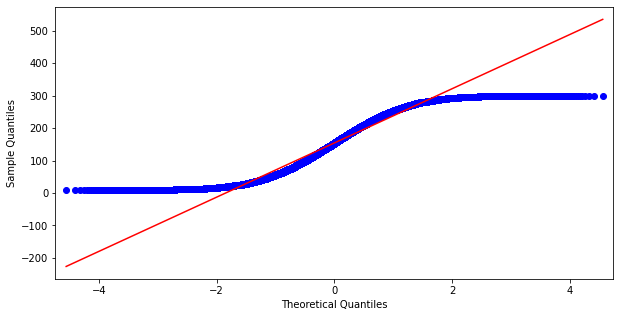

In [ ]:
#Plotting the QQ Plots of the continuous numerical variables
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
continuousvariables=['Age','Region_Code','Annual_Premium','Vintage']
for variable in continuousvariables:
 print('The qq plot for '+ variable + ' is: ')
 fig = sm.qqplot(df[variable],line='s')
 plt.show();
 print()

The continuous variables show normal or Gaussian distribution (red line) for the most part of their range, with deviations of left and right skews on their extremes, maybe due to outliers present.

Count of positive and negative responses to purchasing insurance vs. their vehicle age


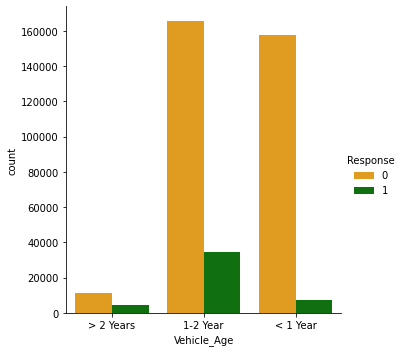

In [ ]:
#To visualize how the vehicle age affects the possibility of a customer responding positively to purchasing vehicle insurance
print('Count of positive and negative responses to purchasing insurance vs. their vehicle age')
fig, ax = plt.subplots()

sns.catplot('Vehicle_Age', hue="Response", data=df, kind="count", 
            palette={1:"green", 0:"orange"}, ax=ax)


plt.close(1)
ax.set_xlabel("Vehicle_Age")

color_patches = [
    Patch(facecolor="green", label='Customer interested to purchase vehicle insurance'),
    Patch(facecolor="orange", label="Customer is not interested to purchase vehicle insurance")
]
ax.legend(handles=color_patches)

plt.show();

Out of the entire dataset, customers with >2 years of vehicle age were very few, and of the rest of the customers, the majority of interested customers had their vehicle age in 1-2 years. This may be due to reasons of experience in driving their vehicle, and the need for insurance making itself known only after sufficient time has passed while driving.

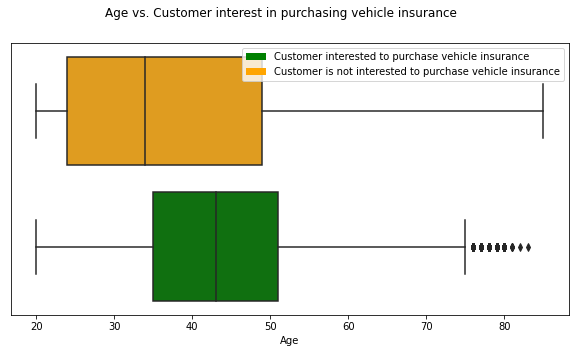

In [ ]:
#To see how age affects the possibility of a stroke occuring
fig, ax = plt.subplots()

sns.boxplot(x="Age", y="Response", data=df, orient="h", palette={1:"green", 0:"orange"}, ax=ax)

ax.get_yaxis().set_visible(False)

fig.suptitle("Age vs. Customer interest in purchasing vehicle insurance")
color_patches = [
    Patch(facecolor="green", label="Customer interested to purchase vehicle insurance"),
    Patch(facecolor="orange", label="Customer is not interested to purchase vehicle insurance")
]
ax.legend(handles=color_patches);

Elder people were more inclined towards purchasing vehicle insurance, which may be attributed to experience, and more interest in protecting their assets due to reasons of family and financial causes.

##Data Pre-processing:

In [ ]:
df=df.drop(columns=['id']) #dropping features which have no role to play in predicting the target variable

In [ ]:
#One-hot encoding categorical variables
categorical_cols = ['Gender','Driving_License','Vehicle_Age','Previously_Insured','Vehicle_Damage']
df = pd.get_dummies(df, columns = categorical_cols)

display(df)

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes
0,44,28.0,40454.0,26.0,217,1,0,1,0,1,0,0,1,1,0,0,1
1,76,3.0,33536.0,26.0,183,0,0,1,0,1,1,0,0,1,0,1,0
2,47,28.0,38294.0,26.0,27,1,0,1,0,1,0,0,1,1,0,0,1
3,21,11.0,28619.0,152.0,203,0,0,1,0,1,0,1,0,0,1,1,0
4,29,41.0,27496.0,152.0,39,0,1,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,74,26.0,30170.0,26.0,88,0,0,1,0,1,1,0,0,0,1,1,0
381105,30,37.0,40016.0,152.0,131,0,0,1,0,1,0,1,0,0,1,1,0
381106,21,30.0,35118.0,160.0,161,0,0,1,0,1,0,1,0,0,1,1,0
381107,68,14.0,44617.0,124.0,74,0,1,0,0,1,0,0,1,1,0,0,1


In [ ]:
#Scaling continuous variables
continuousvariables=['Age', 'Region_Code', 'Annual_Premium','Vintage','Policy_Sales_Channel']
for col in continuousvariables:
  df[col]=(df[col]-df[col].mean())/df[col].std()
display(df)

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes
0,0.333777,0.121784,0.574538,-1.587232,0.748794,1,0,1,0,1,0,0,1,1,0,0,1
1,2.396748,-1.767876,0.172636,-1.587232,0.342442,0,0,1,0,1,1,0,0,1,0,1,0
2,0.527180,0.121784,0.449053,-1.587232,-1.521996,1,0,1,0,1,0,0,1,1,0,0,1
3,-1.148983,-1.163185,-0.113018,0.737320,0.581473,0,0,1,0,1,0,1,0,0,1,1,0
4,-0.633241,1.104408,-0.178258,0.737320,-1.378578,0,1,0,0,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,2.267812,-0.029389,-0.022912,-1.587232,-0.792953,0,0,1,0,1,1,0,0,0,1,1,0
381105,-0.568773,0.802062,0.549092,0.737320,-0.279037,0,0,1,0,1,0,1,0,0,1,1,0
381106,-1.148983,0.272957,0.264542,0.884911,0.079509,0,0,1,0,1,0,1,0,0,1,1,0
381107,1.881005,-0.936426,0.816388,0.220753,-0.960274,0,1,0,0,1,0,0,1,1,0,0,1


In [ ]:
#shuffling the data to get rid of any underlying order that may exist
df = df.sample(frac = 1) 
display(df)

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_Female,Gender_Male,Driving_License_0,Driving_License_1,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_No,Vehicle_Damage_Yes
332703,1.816537,0.121784,-0.242802,-1.587232,1.370274,0,0,1,0,1,1,0,0,0,1,1,0
149642,-0.697709,-1.389944,-0.512712,0.737320,0.856358,0,0,1,0,1,0,1,0,1,0,1,0
353351,-0.762176,0.726476,-0.266272,0.737320,-0.434407,0,1,0,0,1,0,1,0,1,0,0,1
76562,-1.020048,1.406754,0.015837,0.737320,-1.701269,0,1,0,0,1,0,1,0,0,1,1,0
38034,0.398245,0.726476,-0.044698,0.774218,-0.506116,0,0,1,0,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348983,-0.697709,-1.163185,0.560595,0.737320,-0.290989,0,0,1,0,1,0,1,0,1,0,0,1
283611,-0.955580,-1.163185,0.594639,0.737320,0.736843,0,1,0,0,1,0,1,0,0,1,1,0
345467,-1.020048,1.482340,-0.149095,0.737320,0.951970,0,0,1,0,1,0,1,0,0,1,1,0
374978,-1.148983,-1.767876,0.367022,0.884911,-0.302940,0,1,0,0,1,0,1,0,1,0,0,1


In [ ]:
#Preparing the data for training the model
X= df.drop(['Response'], axis=1)
Y= df['Response']
print(len(X)) #number of samples

381109


To split our dataset into training and testing sets, we do the following. Due to insufficient computational power, the entire dataset could not be considered while training our model, and hence a third counterpart named 'extra' has been defined to store the remaining records not used in training and testing.

In [ ]:
#Splitting X and Y into training, validation and test sets in 70:15:15 ratio

from sklearn.model_selection import train_test_split
# Defines ratios, w.r.t. whole dataset.
ratio_train = 0.15
ratio_extra = 0.75
ratio_test = 0.10

# Produces test split.
X_remaining, X_test, Y_remaining, Y_test = train_test_split(
    X, Y, test_size=ratio_test)

# Adjusts val ratio, w.r.t. remaining dataset.
ratio_remaining = 1 - ratio_test
ratio_extra_adjusted = ratio_extra / ratio_remaining

# Produces train and val splits.
X_train, X_extra, Y_train, Y_extra = train_test_split(
    X_remaining, Y_remaining, test_size=ratio_extra_adjusted)

print(X_train.shape)
print(Y_train.shape)
print(X_extra.shape)
print(Y_extra.shape)
print(X_test.shape)
print(Y_test.shape)

(57166, 16)
(57166,)
(285832, 16)
(285832,)
(38111, 16)
(38111,)


In [ ]:
from sklearn.utils import resample
#combine them back for resampling
train_data = pd.concat([X_train, Y_train], axis=1)
# separate minority and majority classes
negative = train_data[train_data.Response==0]
positive = train_data[train_data.Response==1]
# downsample majority
neg_downsampled = resample(negative, replace=True, # sample with replacement
n_samples=len(positive), # match number in minority class
random_state=27) # reproducible results
# combine minority and downsampled majority
downsampled = pd.concat([positive, neg_downsampled])
# check new class counts
downsampled.Response.value_counts()


1    7103
0    7103
Name: Response, dtype: int64

Resampling has been done on our training dataset to deal with our highly unbalanced dataset to prevent overfitting (predicting all responses as 0). We use the undersampling method, wherein it involves removing samples from the majority class.

In [ ]:
#Preparing the data for training the model using our resampled data 
X_train= downsampled.drop(['Response'], axis=1)
Y_train= downsampled['Response']
print(len(X_train)) #number of samples

14206


##Model Building and Hyperparameter tuning:

Support Vector Machine has been selected as the model that would classify our samples into positive and negative responses towards the idea of purchasing vehicle insurance. 

In [ ]:
# Fit this best model to training data
from sklearn.svm import SVC
classifier_svc = SVC(C=10, gamma='scale', kernel='poly')
classifier_svc.fit(X_train, Y_train)

SVC(C=10, kernel='poly')

Due to computational constraints, hyperparameter tuning using GridSearchCV could not be utilized. However, various combinations of hyperaprameter values C(0.1/1/10) and kernel (rbf/poly) have been tried on our training dataset manually to look for the best hyperparameter combination.

In [ ]:
# Evaluate on test set 
Y_pred = classifier_svc.predict(X_test)

##Model performance:

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     33495
           1       0.28      0.93      0.42      4616

    accuracy                           0.70     38111
   macro avg       0.63      0.80      0.61     38111
weighted avg       0.90      0.70      0.75     38111

Mean Square Error: 0.30434782608695654


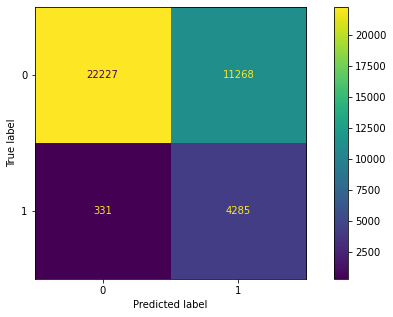

In [ ]:
# Performance Statistics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
print(classification_report(Y_test, Y_pred))
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot();

from sklearn.metrics import mean_squared_error
print(f"Mean Square Error: {mean_squared_error(Y_test,Y_pred)}")

An accuracy of 88% had been achieved if resampling was not performed, however the confusion matrix depicted all positive (1) responses to be falsely predicted as negative (0), thus resulting in overfitting of the model onto our dataset. From previous analysis, we observed that the dataset was largely skewed with majority of the responses as negative. Thus though our accuracy decreases, we now have a model that generalizes well to predict new customer responses towards the possibility of vehicl insurance purchase. 